In [ ]:
# https://github.com/ibab/tensorflow-wavenet
# https://machinelearningmastery.com/stacked-long-short-term-memory-networks/
# https://deepmind.com/blog/article/wavenet-generative-model-raw-audio
# https://stats.stackexchange.com/questions/347431/do-neural-networks-learn-a-function-or-a-probability-density-function/347486#347486
# https://ruder.io/multi-task/

# sequence to sequence ()
# seva's model?


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

# from RNN_116 import vaeRNN  # 116 units
from RNN import vaeRNN        # 46 units


import sys
import time
import random
import numpy as np
import cv2  # conda install opencv
import pickle


import matplotlib.pyplot as plt
from tabulate import tabulate
from utils import printProgressBar


def loadset(device, normalize_to_01):
    fname = np.random.choice(['DS0.dat', 'DS1.dat','DS2.dat','DS3.dat'])

    with open(fname, 'rb') as f:
        dat = pickle.load(f)

    IMG = dat['img']
    joints = dat['joints']
    times = dat['t']

    joints /= 4.0

    img = np.stack(IMG)
    img = img.transpose(0,3,1,2) #B x C x H x W
    img = img[:,0,:,:]           # select only the red channel
    img = img[:,None, :,:]       # squeeze the tensor
    visual_input = torch.tensor(img, dtype=torch.float).to(device)

    # prepare visual targets (they should be the same as the inputs only one step ahead)
    visual_target = np.roll(img, -1, axis=0)
    visual_target = torch.tensor(visual_target, dtype=torch.float).to(device)
    
    if normalize_to_01:
        visual_input /= 255.
        visual_target /= 255.

    motor_input = torch.tensor(joints, dtype=torch.float).to(device)

    target_joints = np.roll(joints, -1, axis=0)
    motor_target = torch.tensor(target_joints, dtype=torch.float).to(device)
    return IMG, joints, visual_input, motor_input, visual_target, motor_target

In [2]:

input_size  = 46 # 116
hidden_size = 46 # 116
output_size = 46 # 116
cell_type = 'GRU'
device = 'cuda'
normalize_to_01 = False
num_rnn_layers = 2

rnn = vaeRNN(cell_type, input_size, hidden_size, output_size, num_rnn_layers).to(device)

# rnn.load_state_dict(torch.load('checkpoint'))

hidden = rnn.initHidden(device=device)
IMG, joints, visual_input, motor_input, visual_target, motor_target = loadset(device, normalize_to_01)
visual_output, motor_output, hidden, mu, logsig = rnn(visual_input, motor_input, hidden, True)

VLOSS, MLOSS = [], []
name = ''.join(random.sample('abcdefgh1234567890', 10))
writer = SummaryWriter('runs/' + name)

In [14]:
reparametrize = True
bigdataset = True

pred_fb = 0                                 # fraction of feedback at each step (ground truth = 1 - pred_fb)
# we use mse loss for visual reconstruction (because it is basically regression, not classification).
# xent is more appropriate for classification. In the VAE tutorial tehy use xent, because
# teh MNIST dataset roughly follows the multivariate Bernoulli distribution (i.e. pixels tend to be
# close to 0 or 1 (when scaled to zero or one)). Than's why xent works nicely with the VAE.
# when you use MSE, you get more jagged images, because unlike xent MSE is unbiased towards 0.5. For more:
# https://stats.stackexchange.com/questions/350211/loss-function-autoencoder-vs-variational-autoencoder-or-mse-loss-vs-binary-cross
motor_crit = 'mse'
visual_crit = 'mse' # !!! if xent, scale pixels to [0, 1] and activate decoder's output with a sigmoid !!!
EPOCHS = 500000
LRATE = 0.00025
balance_loss = True
mloss_boost = 1.5
rnn.optimizer = optim.Adam(rnn.parameters(), lr=LRATE)



crit = {}
crit['mse'] = nn.MSELoss()
crit['xent'] = nn.BCELoss(reduction='sum')

def loss_balancer(vl, ml, kl):
    global mloss_boost
    total_loss_ = vl + ml + kl
    visual_mult = total_loss_ / 3.0 / vl
    motor_mult = total_loss_ / 3.0 / ml * mloss_boost
    Dkl_mult = total_loss_ / 3.0 / kl
    s = visual_mult + motor_mult + Dkl_mult
    return visual_mult/s, motor_mult/s, Dkl_mult/s


print('PREDICTION FEEDBACK: {}\n'.format(pred_fb))
printProgressBar(0, EPOCHS, prefix = 'Progress:', suffix = 'Complete', length = 25)
for epoch in range(EPOCHS):
    try:
        if epoch%5 == 0 and bigdataset:
            IMG, joints, visual_input, motor_input, visual_target, motor_target = loadset(device, normalize_to_01)
        
        # forward the first step in the sequence:
        hidden = rnn.initHidden(device=device)
        visual_output, motor_output, hidden, mu, logsig =   rnn(visual_input[0].unsqueeze(0),
                                                            motor_input[0].unsqueeze(0),
                                                            hidden,
                                                            train=reparametrize)  
        rnn.optimizer.zero_grad()
        loss = torch.zeros(1,).to(device)
        
        if pred_fb == 0:
            (visual_output,
             motor_output,
             hidden,
             mu,
             logsig) = rnn(visual_input,
                           motor_input,
                           hidden,
                           train=reparametrize)

            motor_loss = crit[motor_crit](motor_output, motor_target)
            visual_loss = crit[visual_crit](visual_output, visual_target)
            kl_loss = rnn.KL(mu, logsig)
            
            if balance_loss:
                visual_mult, motor_mult, Dkl_mult = loss_balancer(visual_loss.item(),
                                                                  motor_loss.item(), 
                                                                  kl_loss.item())
            else:
                visual_mult, motor_mult, Dkl_mult = 1, 1, 1  
            loss = visual_loss*visual_mult + motor_loss*motor_mult*mloss_boost + kl_loss*Dkl_mult
            
        else:
            for i in range(1, motor_input.shape[0]):
                (visual_output,
                 motor_output,
                 hidden,
                 mu,
                 logsig) = rnn(visual_input[i].unsqueeze(0)*(1-pred_fb) + visual_output*pred_fb,
                               motor_input[i].unsqueeze(0)*(1-pred_fb) + motor_output.unsqueeze(0)*pred_fb,
                               hidden,
                               train=reparametrize)

                motor_loss = crit[motor_crit](motor_output.unsqueeze(0), motor_target[i].unsqueeze(0))
                visual_loss = crit[visual_crit](visual_target[i].unsqueeze(0), visual_output)
                kl_loss = rnn.KL(mu, logsig)
                
                if balance_loss:
                    visual_mult, motor_mult, Dkl_mult = loss_balancer(visual_loss.item(),
                                                                      motor_loss.item(), 
                                                                      kl_loss.item())
                else:
                    visual_mult, motor_mult, Dkl_mult = 1, 1, 1
                loss += visual_loss*visual_mult + motor_loss*motor_mult + kl_loss*Dkl_mult

        loss.backward()
        writer.add_scalar('motor loss', motor_loss, epoch)
        writer.add_scalar('visual loss', visual_loss, epoch)
        writer.add_scalar('KL loss', kl_loss, epoch)
            
        VLOSS.append(visual_loss.item())
        MLOSS.append(motor_loss.item())
        rnn.optimizer.step()
        printProgressBar(epoch + 1,
                         EPOCHS,
                         prefix='Ep.: {} | vl ({}): {:.1f} | ml ({}): {:.6f} | KL: {:.3f} | vw: {:.3f}, mw: {:.3f}, kw: {:.3f}'.format(
                             epoch,
                             visual_crit, visual_loss.item(), 
                             motor_crit, motor_loss.item(), 
                             kl_loss.item(),
                             visual_mult, motor_mult, Dkl_mult),
                         suffix='', length=10)
        if epoch % 1000 == 0:
            torch.save(rnn.state_dict(), 'checkpoint')

    except KeyboardInterrupt:
        print('\nKeyboard Interrupt')
        break

PREDICTION FEEDBACK: 0

Ep.: 199675 | vl (mse): 369.7 | ml (mse): 0.000107 | KL: 0.000 | vw: 0.000, mw: 0.776, kw: 0.224 |███-------| 39.9% 0% 
Keyboard Interrupt


In [15]:
torch.save(rnn.state_dict(), 'checkpoint')
# rnn.load_state_dict(torch.load('checkpoint_vaeRNN_1K_iter_noBIG_mse'))

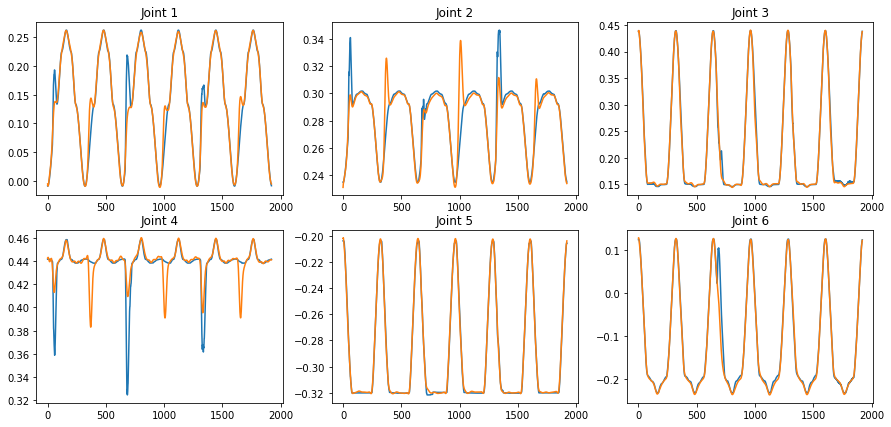

In [16]:
""" without prediction feedback """

%matplotlib inline

reparametrize = False

IMG, joints, visual_input, motor_input, visual_target, motor_target = loadset(device, normalize_to_01)
OUT = []

hidden = rnn.initHidden(device=device)
visual_output, motor_output, hidden, mu, logsig =   rnn(visual_input[0].unsqueeze(0),
                                                        motor_input[0].unsqueeze(0),
                                                        hidden,
                                                        train=reparametrize)

for i in range(len(IMG)):
    (visual_output,
     motor_output,
     hidden,
     mu,
     logsig) = rnn(visual_input[i,:,:,:].view(-1,1,64,64),
                   motor_input[i,:].view(-1,16),
                   hidden,
                   train=reparametrize)
    
    OUT.append(motor_output.cpu().detach().numpy())
OUT = np.stack(OUT).squeeze()
IN = motor_input.cpu().detach().numpy()

plt.figure(figsize=(15,7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(IN[:, i])
    plt.plot(OUT[:, i])
    plt.title('Joint {}'.format(i+1))

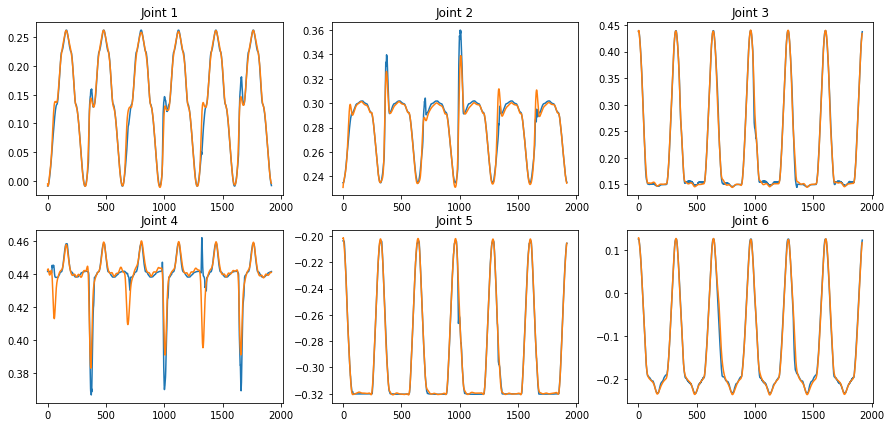

In [17]:
""" with prediction feedback """

%matplotlib inline

reparametrize = False

IMG, joints, visual_input, motor_input, visual_target, motor_target = loadset(device, normalize_to_01)
OUT = []

hidden = rnn.initHidden(device=device)
visual_output, motor_output, hidden, mu, logsig =   rnn(visual_input[0].unsqueeze(0),
                                                        motor_input[0].unsqueeze(0),
                                                        hidden,
                                                        train=reparametrize)

for i in range(1, len(IMG)):
    (visual_output,
     motor_output,
     hidden,
     mu,
     logsig) = rnn(visual_output,
                   motor_output,
                   hidden,
                   train=reparametrize)
    OUT.append(motor_output.cpu().detach().numpy())
    
OUT = np.stack(OUT).squeeze()
IN = motor_input.cpu().detach().numpy()

plt.figure(figsize=(15,7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(IN[:, i])
    plt.plot(OUT[:, i])
    plt.title('Joint {}'.format(i+1))

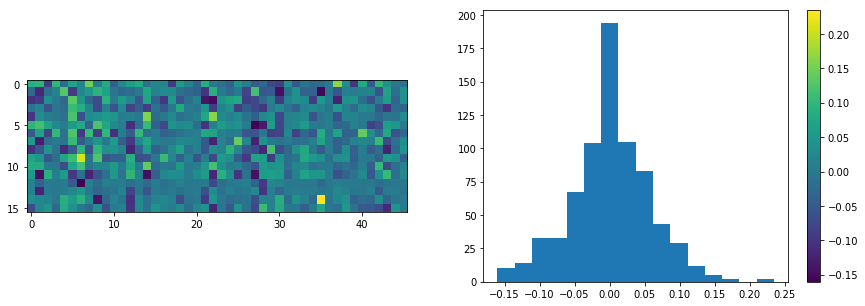

In [18]:
""" plot weight distribution of a particular layer """

w = rnn.fc3.weight.cpu().detach().numpy()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(w)
plt.subplot(1,2,2)
plt.hist(w.flatten(), bins=16)
plt.colorbar()

In [19]:
""" MONITOR """


cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

i = 0
while True:
    try:
        time.sleep(0.1)
        
        im1 = cv2.resize(visual_input[i,:,:].squeeze().cpu().detach().numpy(), (350, 350), interpolation = cv2.INTER_AREA)
        im1 = cv2.normalize(im1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        visual_output, motor_output, hidden, mu, logsig = rnn(visual_input[i,:,:,:].unsqueeze_(0), 
                                          motor_input[i,:].unsqueeze_(0),
                                          hidden,
                                          train=False)
        im2 = cv2.resize(visual_output.squeeze().cpu().detach().numpy(), (350, 350), interpolation = cv2.INTER_AREA)
        im2 = cv2.normalize(im2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        final_frame = cv2.hconcat((im1, im2))
        cv2.imshow('I see', final_frame)
        
        k = cv2.waitKey(3) & 0XFF
        if k== 27 :
            cv2.destroyWindow('I see')
            break
        i += 1
    except:
        cv2.destroyWindow('I see')
        break